# Laboratorium 2 - Klasyfikacja algorytmem k-najbliższych sąsiadów (k-nn)

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris, load_wine
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Klasyfikacja k-nn dla zbioru IRIS

In [180]:
iris = load_iris()
df_iris = pd.DataFrame(data = iris.data, columns = iris.feature_names)
df_iris['target'] = iris.target
df_iris['target names'] = iris.target_names[df_iris['target']]
df_iris.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target target names  
0       0       setosa  
1       0       setosa  
2       0       setosa  
3       0       setosa  
4       0       setosa

In [181]:
# Dystrybucja klas w zbiorze
class_labels = iris.target
unique_classes, counts = np.unique(class_labels, return_counts = True)

for i, class_name in enumerate(iris.target_names):
    print(f'{class_name}: {counts[i]}')

setosa: 50
versicolor: 50
virginica: 50


In [182]:
df_iris.isna().any()

sepal length (cm)    False
sepal width (cm)     False
petal length (cm)    False
petal width (cm)     False
target               False
target names         False
dtype: bool

In [183]:
df_iris.iloc[:, :4].columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

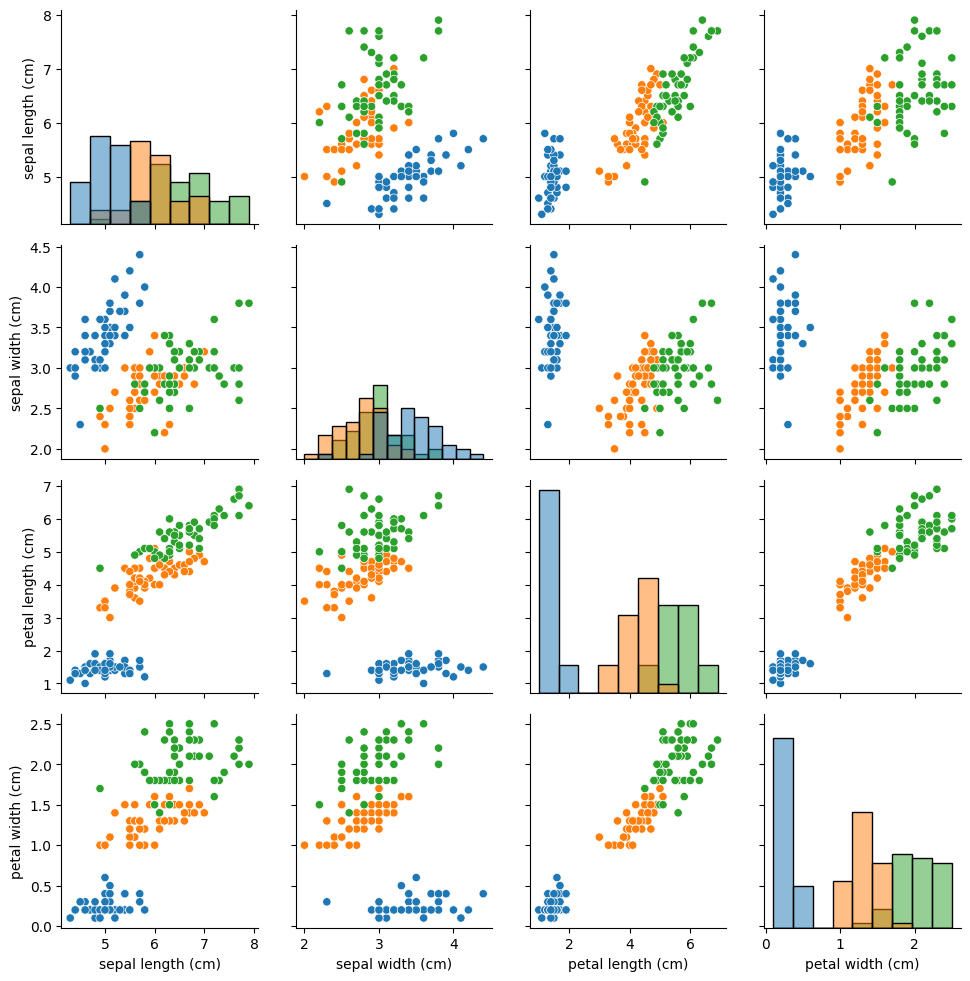

In [184]:
x_vars = df_iris.iloc[:, :4].columns
y_vars = x_vars

g = sns.PairGrid(df_iris, hue = 'target names', x_vars = x_vars, y_vars = y_vars)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

In [185]:
X_iris = iris.data
y_iris = iris.target

In [186]:
def plain_knn(X, y, n_neighbors = 5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)
    
    pipe = Pipeline([('normalize', Normalizer()), ('knn', KNeighborsClassifier(n_neighbors = n_neighbors))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return y_test, y_pred

In [187]:
plain_knn_iris = plain_knn(X_iris, y_iris)
print(classification_report(*plain_knn_iris))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.92      0.96        13
           2       0.93      1.00      0.96        13

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



In [188]:
print(f'Precision: {precision_score(*plain_knn_iris, average = "weighted")}')
print(f'Accuracy: {accuracy_score(*plain_knn_iris)}')
print(f'Recall: {recall_score(*plain_knn_iris, average = "weighted")}')
print(f'F1: {f1_score(*plain_knn_iris, average = "weighted")}')

Precision: 0.9755639097744361
Accuracy: 0.9736842105263158
Recall: 0.9736842105263158
F1: 0.9736452241715399


### 4. Implementacja procedury walidacji krzyżowej

In [189]:
def cv_knn(n_splits, X, y
           , shuffle = True
           , n_neighbors = 5
           , metric = "minkowski"
           , p = 2
           , metric_params = None
           , weights = None
           , cv_method = KFold):

    kf = cv_method(n_splits = n_splits, shuffle = shuffle)
    pipe = Pipeline([('normalize', Normalizer()), ('knn', KNeighborsClassifier(n_neighbors = n_neighbors
                                                                               , metric = metric
                                                                               , p = p
                                                                               , metric_params = metric_params
                                                                               , weights = weights))])
    scores = []
    
    if cv_method == KFold:
        splt = kf.split(X)
    elif cv_method == StratifiedKFold:
        splt = kf.split(X, y)
        
    for train_index, test_index in splt:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)

    # Średnia dokładność z k-fold walidacji
    mean_score = np.mean(scores)
    return mean_score


def loo_knn(X, y, n_neighbors = 5):

    loo = LeaveOneOut()
    loo.get_n_splits(X)
    pipe = Pipeline([('normalize', Normalizer()), ('knn', KNeighborsClassifier(n_neighbors = n_neighbors))])
    scores = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)

    # Średnia dokładność z k-fold walidacji
    mean_score = np.mean(scores)
    return mean_score

In [190]:
print('KFold accuracy without shuffling: \n')
print(f'2-fold CV accuracy: {cv_knn(2, X_iris, y_iris, shuffle = False)}')
print(f'5-fold CV accuracy: {cv_knn(5, X_iris, y_iris, shuffle = False)}')
print(f'10-fold CV accuracy: {cv_knn(10, X_iris, y_iris, shuffle = False)}')

KFold accuracy without shuffling: 

2-fold CV accuracy: 0.30666666666666664
5-fold CV accuracy: 0.9400000000000001
10-fold CV accuracy: 0.9533333333333334


In [191]:
print('KFold accuracy with shuffling: \n')
print(f'2-fold CV accuracy: {cv_knn(2, X_iris, y_iris)}')
print(f'5-fold CV accuracy: {cv_knn(5, X_iris, y_iris)}')
print(f'10-fold CV accuracy: {cv_knn(10, X_iris, y_iris)}')

KFold accuracy with shuffling: 

2-fold CV accuracy: 0.9666666666666667
5-fold CV accuracy: 0.9666666666666668
10-fold CV accuracy: 0.9666666666666666


Implementacja walidacji krzyżowej z uwzględnieniem parametru shuffle skutkuje znacznie lepszymi rezultatami, aniżeli bez niego. Dzieje się tak, ponieważ odpowiada on za losowe przemieszanie zbioru danych przed jego podziałem na foldy. Gdy jest on ustawiony na False, to dzieli on dane w takiej kolejności, w jakiej występują w zbiorze. W przypadku IRIS dane są wyraźnie posegregowane - najpierw występują kwiaty z klasy 0, później klasy 1, a na końcu z klasy 2. Ponieważ są one różne pod względem cech, przemieszanie zbioru jest niezbędne w celu uzyskania wiarygodnych wyników.

In [192]:
print('LeaveOneOut accuracy: \n')
print(f'LOO accuracy: {loo_knn(X_iris, y_iris)}')


LeaveOneOut accuracy: 



LOO accuracy: 0.9666666666666667


### 5. Testowanie różnych wartości hiperparametrów

#### a) Liczba sąsiadów
Sprawdzimy zmianę jakości klasyfikatora knn względem zmiany argumentu k - liczby sąsiadów. Metryka zostaje domyślna, czyli euklidesowa.

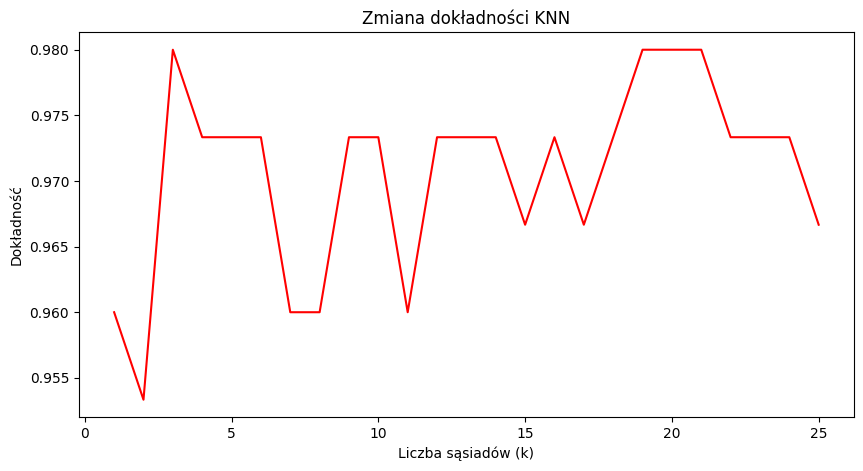

In [193]:
def plot_acc_change(X, y, k = 25, cv_method = KFold):
    neighbors = np.arange(1, k + 1)
    accuracy = np.array([cv_knn(10, X, y, n_neighbors = n, cv_method = cv_method) for n in neighbors])
    fig = plt.figure(figsize = (10, 5))
    plt.plot(neighbors, accuracy, color = 'red')
    plt.xlabel('Liczba sąsiadów (k)')
    plt.ylabel('Dokładność')
    plt.title('Zmiana dokładności KNN')
    plt.show()

plot_acc_change(X_iris, y_iris)

#### b) Metryka
Teraz będziemy rozważali różne metryki i na ich podstawie badali dokładność KNN.

<Axes: >

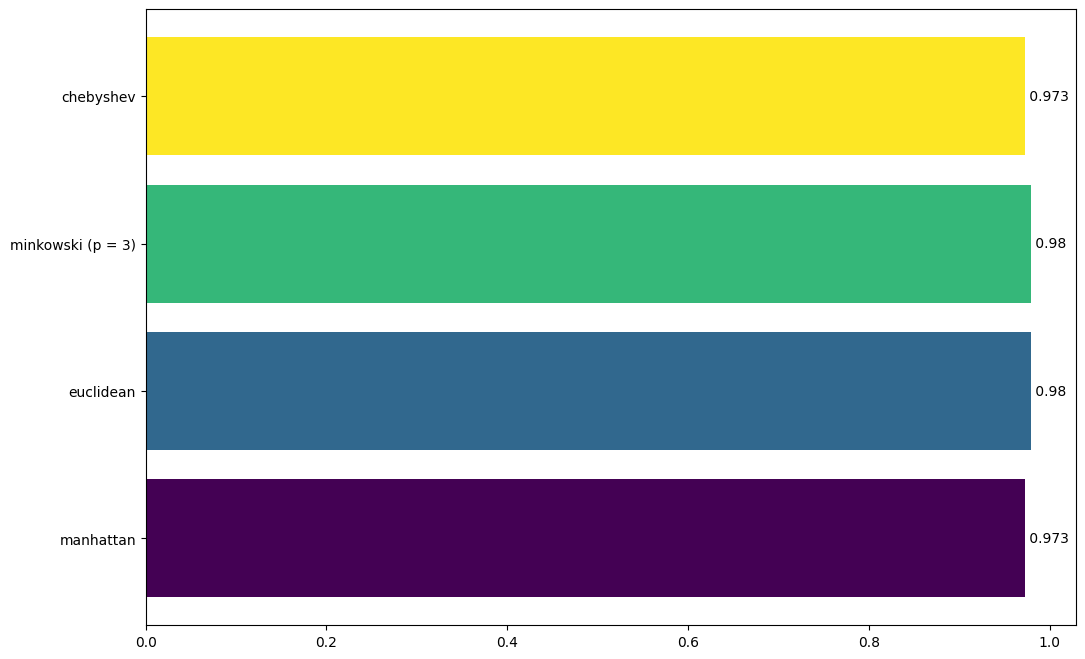

In [228]:
def metrics_plot(X, y, cv_method = KFold):
    accuracy = [cv_knn(10, X, y, n_neighbors = 3, metric = "manhattan", p = None, metric_params = None, cv_method = cv_method)
               , cv_knn(10, X, y, n_neighbors = 3, metric = "euclidean", p = None, metric_params = None, cv_method = cv_method)
               , cv_knn(10, X, y, n_neighbors = 3, metric = "minkowski", p = 3, metric_params = None, cv_method = cv_method)
            #    , cv_knn(10, n_neighbors = 3, metric = "mahalanobis", p = None, metric_params={'V': np.cov(X)})
               , cv_knn(10, X, y, n_neighbors = 3, metric = "chebyshev", p = None, cv_method = cv_method)]
    metrics = ['manhattan', 'euclidean', 'minkowski (p = 3)', 'chebyshev']
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(metrics)))
    fig, ax = plt.subplots(figsize = (12, 8))
    
    ax.barh(metrics, accuracy, color = colors)
    for i, (value, name) in enumerate(zip(accuracy, metrics)):
        ax.text(x = value, y=i, s=f' {round(float(value), 3)}',
            ha='left', va='center', fontsize=10)
    
    return ax

metrics_plot(X_iris, y_iris)

#### c) Sposób głosowania
Tym razem sprawdzimy, jaki wpływ ma sposób głosowania nad przydzieleniem do klasy na osiąganą dokładność. Parametry liczby sąsiadów, oraz metryki pozostaną standardowe. 

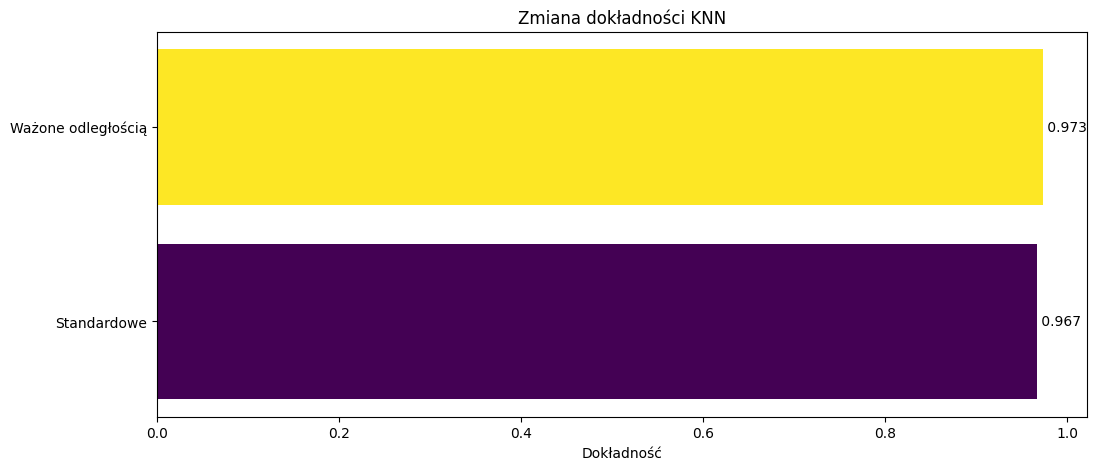

In [195]:
def voting_plot(X, y, cv_method = KFold):
    accuracy = [cv_knn(10, X, y, weights = None, cv_method = cv_method)
               , cv_knn(10, X, y, weights = 'distance', cv_method = cv_method)]
    voting = ['Standardowe', 'Ważone odległością']
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(voting)))
    fig, ax = plt.subplots(figsize = (12, 5))
    
    ax.barh(voting, accuracy, color = colors)
    for i, (value, name) in enumerate(zip(accuracy, voting)):
        ax.text(x = value, y=i, s=f' {round(float(value), 3)}',
            ha='left', va='center', fontsize=10)
    plt.xlabel('Dokładność')
    # plt.ylabel('Dokładność')
    plt.title('Zmiana dokładności KNN')
    plt.show()

voting_plot(X_iris, y_iris)

#### d) Optymalne hiperparametry na podstawie algorytmu GridSearchCV
W celu wyznaczenia optymalnego zestawu hiperparametrów do klasyfikatora KNN zastosujemy algorytm GridSearchCV.

In [196]:
# def optimal_model(X = X_iris, y = y_iris):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)
#     grid = {
#         'knn__n_neighbors' : [(i + 1) for i in range(15)]
#         , 'knn__weights' : ['uniform', 'distance']
#         , 'knn__metric': ['minkowski']
#         , 'knn__p' : [1, 2, 3]
#     }
    
#     pipe = Pipeline([('scaler', Normalizer()), ('knn', KNeighborsClassifier())])
    
#     grid_search = GridSearchCV(pipe, grid, cv = 10, n_jobs = -1)
#     grid_search.fit(X_train, y_train)
    
#     best_params, best_estimator = grid_search.best_params_, grid_search.best_estimator_
#     y_pred = best_estimator.predict(X_test)
#     print(best_params)
#     print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
    
# optimal_model()

## Zbiór WINE

In [197]:
wine = load_wine()
df_wine = pd.DataFrame(data = wine.data, columns = wine.feature_names)
df_wine['target'] = wine.target
df_wine['target names'] = wine.target_names[df_wine['target']]
df_wine

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0          3.06                  0.28             2.29             5.64  1.04   
1          2.76                  0.26             1.28             4.38  1.05   
2          3.24                  0.30             2.81             5.68  1.03   
3          3.49                  0.24             2.18             7.80  0.86   
4          2.69                  0.39             1.82             4.32  1.04   
..          ...                   ...              ...              ...   ...   
173        0.61                  0.52             1.06             7.70  0.64   
174        0.75                  0.43             1.41             7.30  0.70   
175        0.69                  0.43             1.35            10.20  0.59   
176        0.68                  0.53             1.46             9.30  0.60   
177        0.76                  0.56             1.35             9.20  0.61   

     od280/od315_of_diluted_wines  proline  target target names  
0                            3.92   1065.0       0      class_0  
1                            3.40   1050.0       0      class_0  
2                            3.17   1185.0       0      class_0  
3                            3.45   1480.0       0      class_0  
4                            2.93    735.0       0      class_0  
..                            ...      ...     ...          ...  
173                          1.74    740.0       2      class_2  
174                          1.56    750.0       2      class_2  
175                          1.56    835.0       2      class_2  
176                          1.62    840.0       2      class_2  
177                          1.60    560.0       2      class_2  

[178 rows x 15 columns]

In [198]:
# Dystrybucja klas w zbiorze
class_labels = wine.target
unique_classes, counts = np.unique(class_labels, return_counts = True)

for i, class_name in enumerate(wine.target_names):
    print(f'{class_name}: {counts[i]}')

class_0: 59
class_1: 71
class_2: 48


In [199]:
df_wine.isna().any()

alcohol                         False
malic_acid                      False
ash                             False
alcalinity_of_ash               False
magnesium                       False
total_phenols                   False
flavanoids                      False
nonflavanoid_phenols            False
proanthocyanins                 False
color_intensity                 False
hue                             False
od280/od315_of_diluted_wines    False
proline                         False
target                          False
target names                    False
dtype: bool

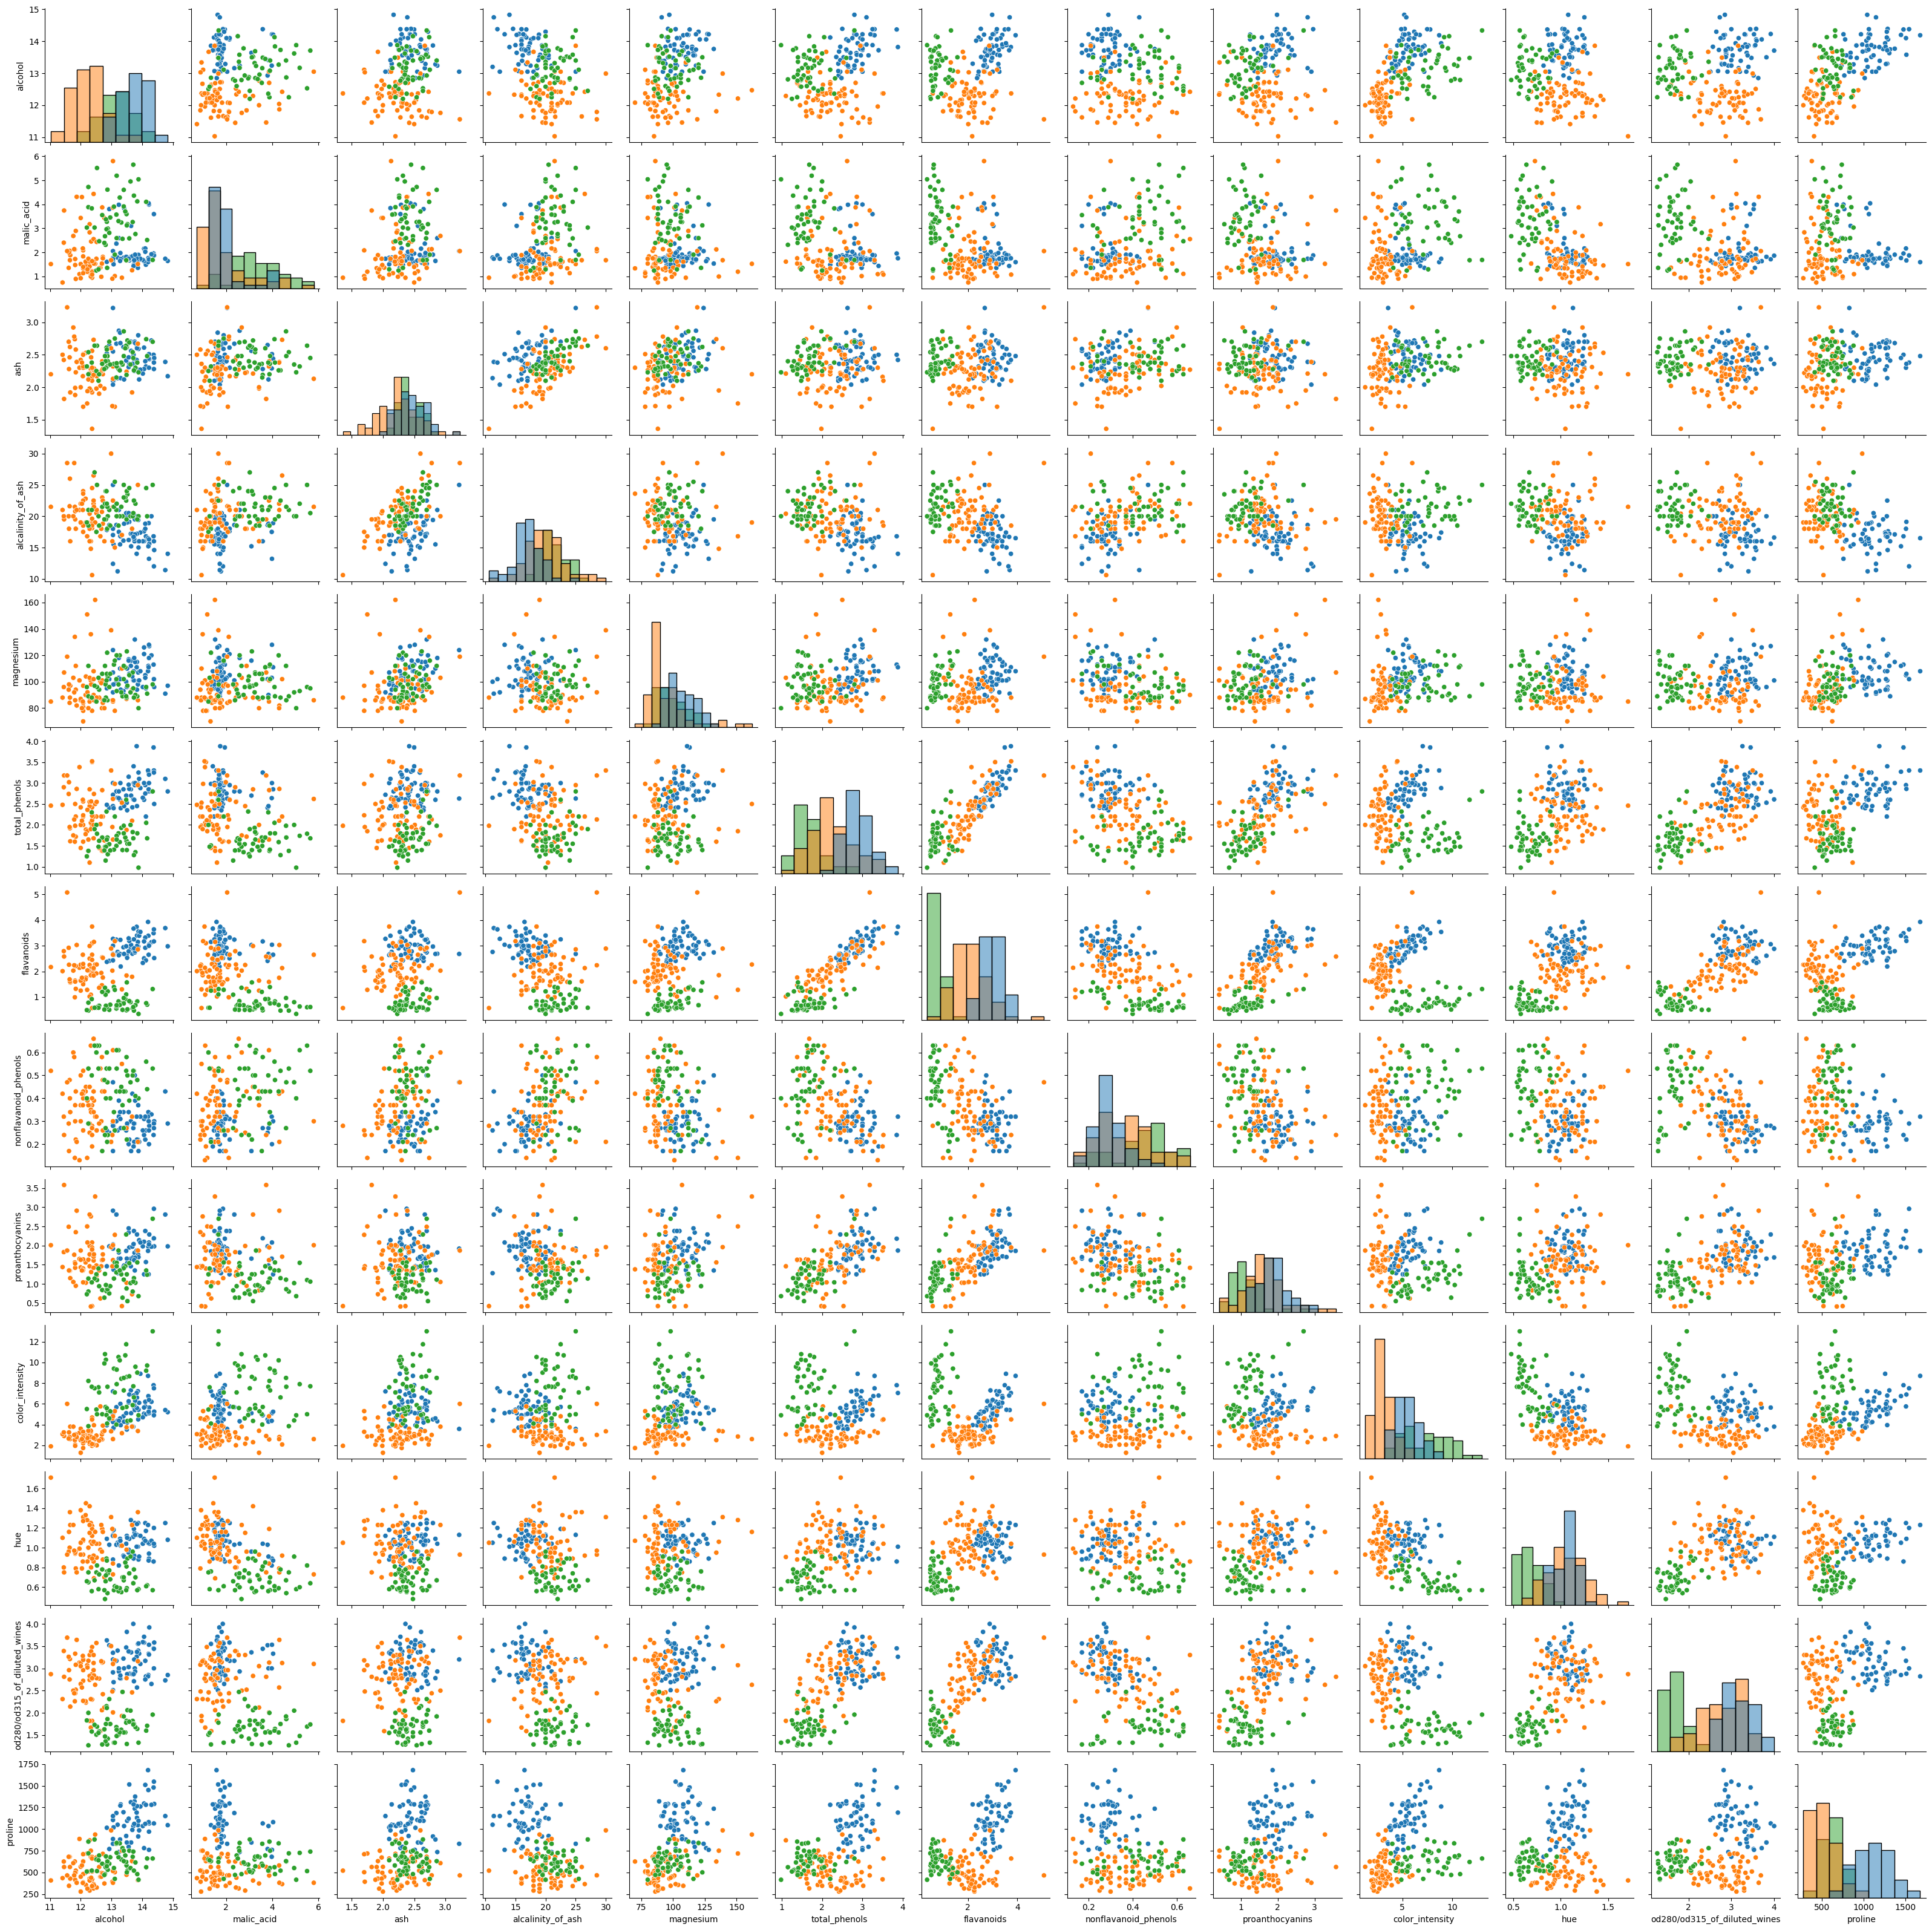

In [200]:
x_vars = df_wine.iloc[:, :-2].columns
y_vars = x_vars

g = sns.PairGrid(df_wine, hue = 'target names', x_vars = x_vars, y_vars = y_vars)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

In [201]:
X_wine = wine.data
y_wine = wine.target

### Skuteczność KNN (domyślne parametry)

In [202]:
plain_knn_wine = plain_knn(X = X_wine, y = y_wine)
print(classification_report(*plain_knn_wine))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.87      0.72      0.79        18
           2       0.79      0.92      0.85        12

    accuracy                           0.84        45
   macro avg       0.84      0.86      0.85        45
weighted avg       0.85      0.84      0.84        45



In [203]:
print(f'Precision: {precision_score(*plain_knn_wine, average = "weighted")}')
print(f'Accuracy: {accuracy_score(*plain_knn_wine)}')
print(f'Recall: {recall_score(*plain_knn_wine, average = "weighted")}')
print(f'F1: {f1_score(*plain_knn_wine, average = "weighted")}')

Precision: 0.847857142857143
Accuracy: 0.8444444444444444
Recall: 0.8444444444444444
F1: 0.841867809609745


### Skuteczność KNN (walidacja krzyżowa - liczba foldów)

In [204]:
print('KFold accuracy with shuffling: \n')
print(f'2-fold CV accuracy: {cv_knn(2, X = X_wine, y = y_wine)}')
print(f'5-fold CV accuracy: {cv_knn(5, X = X_wine, y = y_wine)}')
print(f'10-fold CV accuracy: {cv_knn(10, X = X_wine, y = y_wine)}')
print('\n\n')
print('LeaveOneOut accuracy: \n')
print(f'LOO accuracy: {loo_knn(X = X_wine, y = y_wine)}')

KFold accuracy with shuffling: 

2-fold CV accuracy: 0.7696629213483146
5-fold CV accuracy: 0.7982539682539682
10-fold CV accuracy: 0.8303921568627451



LeaveOneOut accuracy: 

LOO accuracy: 0.8370786516853933


### Skuteczność KNN (walidacja krzyżowa - wartości hiperparametrów)

#### a) Liczba sąsiadów

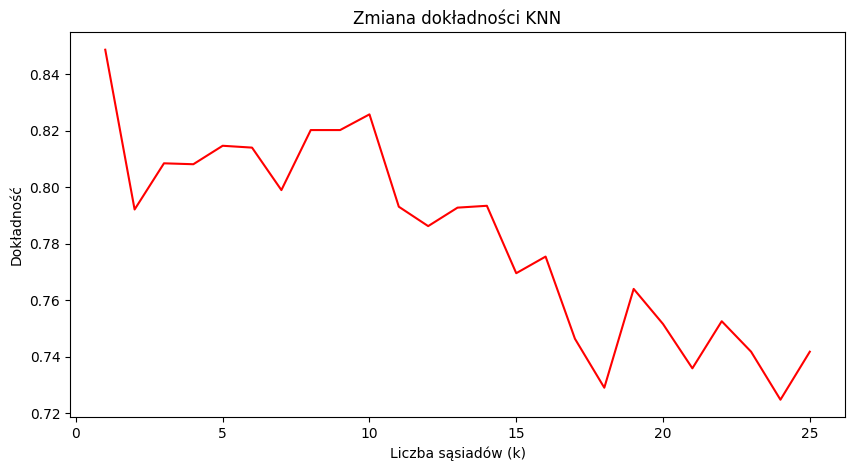

In [205]:
plot_acc_change(X_wine, y_wine)

#### b) Metryka

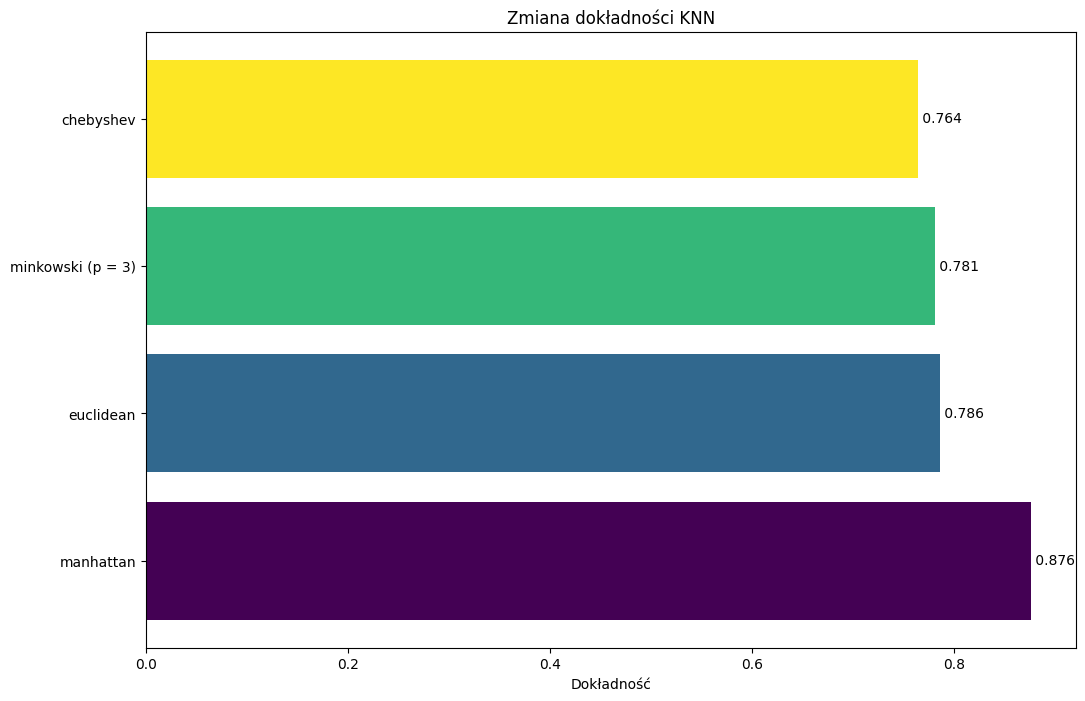

In [206]:
metrics_plot(X_wine, y_wine)

#### c) Sposób głosowania

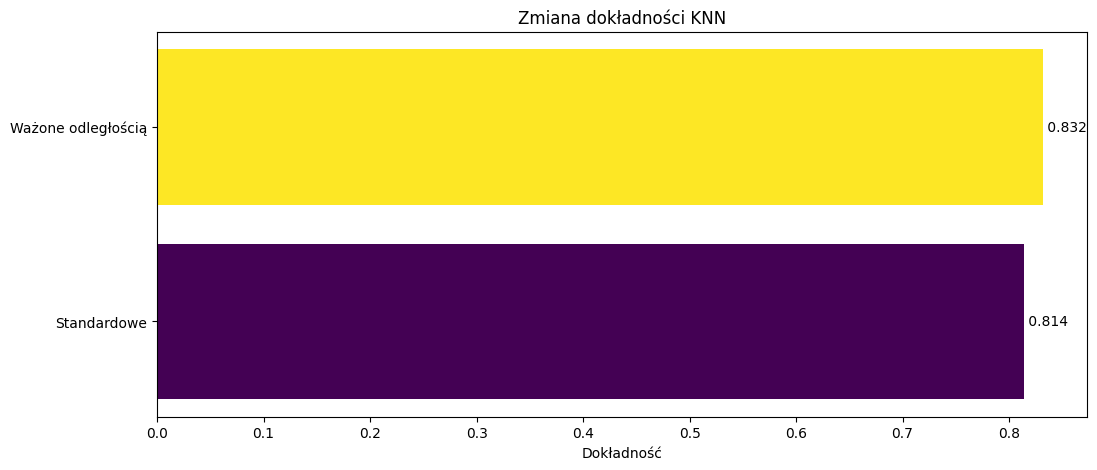

In [207]:
voting_plot(X_wine, y_wine)

## Zbiór GLASS

In [208]:
glass = fetch_ucirepo(id=42) 
X_glass = np.array(glass.data.features) 
y_glass = np.array(glass.data.targets).reshape(1, -1)[0]
df_glass = glass.data.original.drop(['Id_number'], axis = 1)
df_glass

RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type_of_glass
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0              1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0              1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0              1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0              1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0              1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...            ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0              7
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0              7
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0              7
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0              7
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0              7

[214 rows x 10 columns]

In [209]:
# Dystrybucja klas w zbiorze
class_labels = y_glass
unique_classes, counts = np.unique(class_labels, return_counts = True)

for i, class_name in enumerate(np.unique(y_glass)):
    print(f'Class {class_name}: {counts[i]}')

Class 1: 70
Class 2: 76
Class 3: 17
Class 5: 13
Class 6: 9
Class 7: 29


In [210]:
df_glass.isna().any()

RI               False
Na               False
Mg               False
Al               False
Si               False
K                False
Ca               False
Ba               False
Fe               False
Type_of_glass    False
dtype: bool

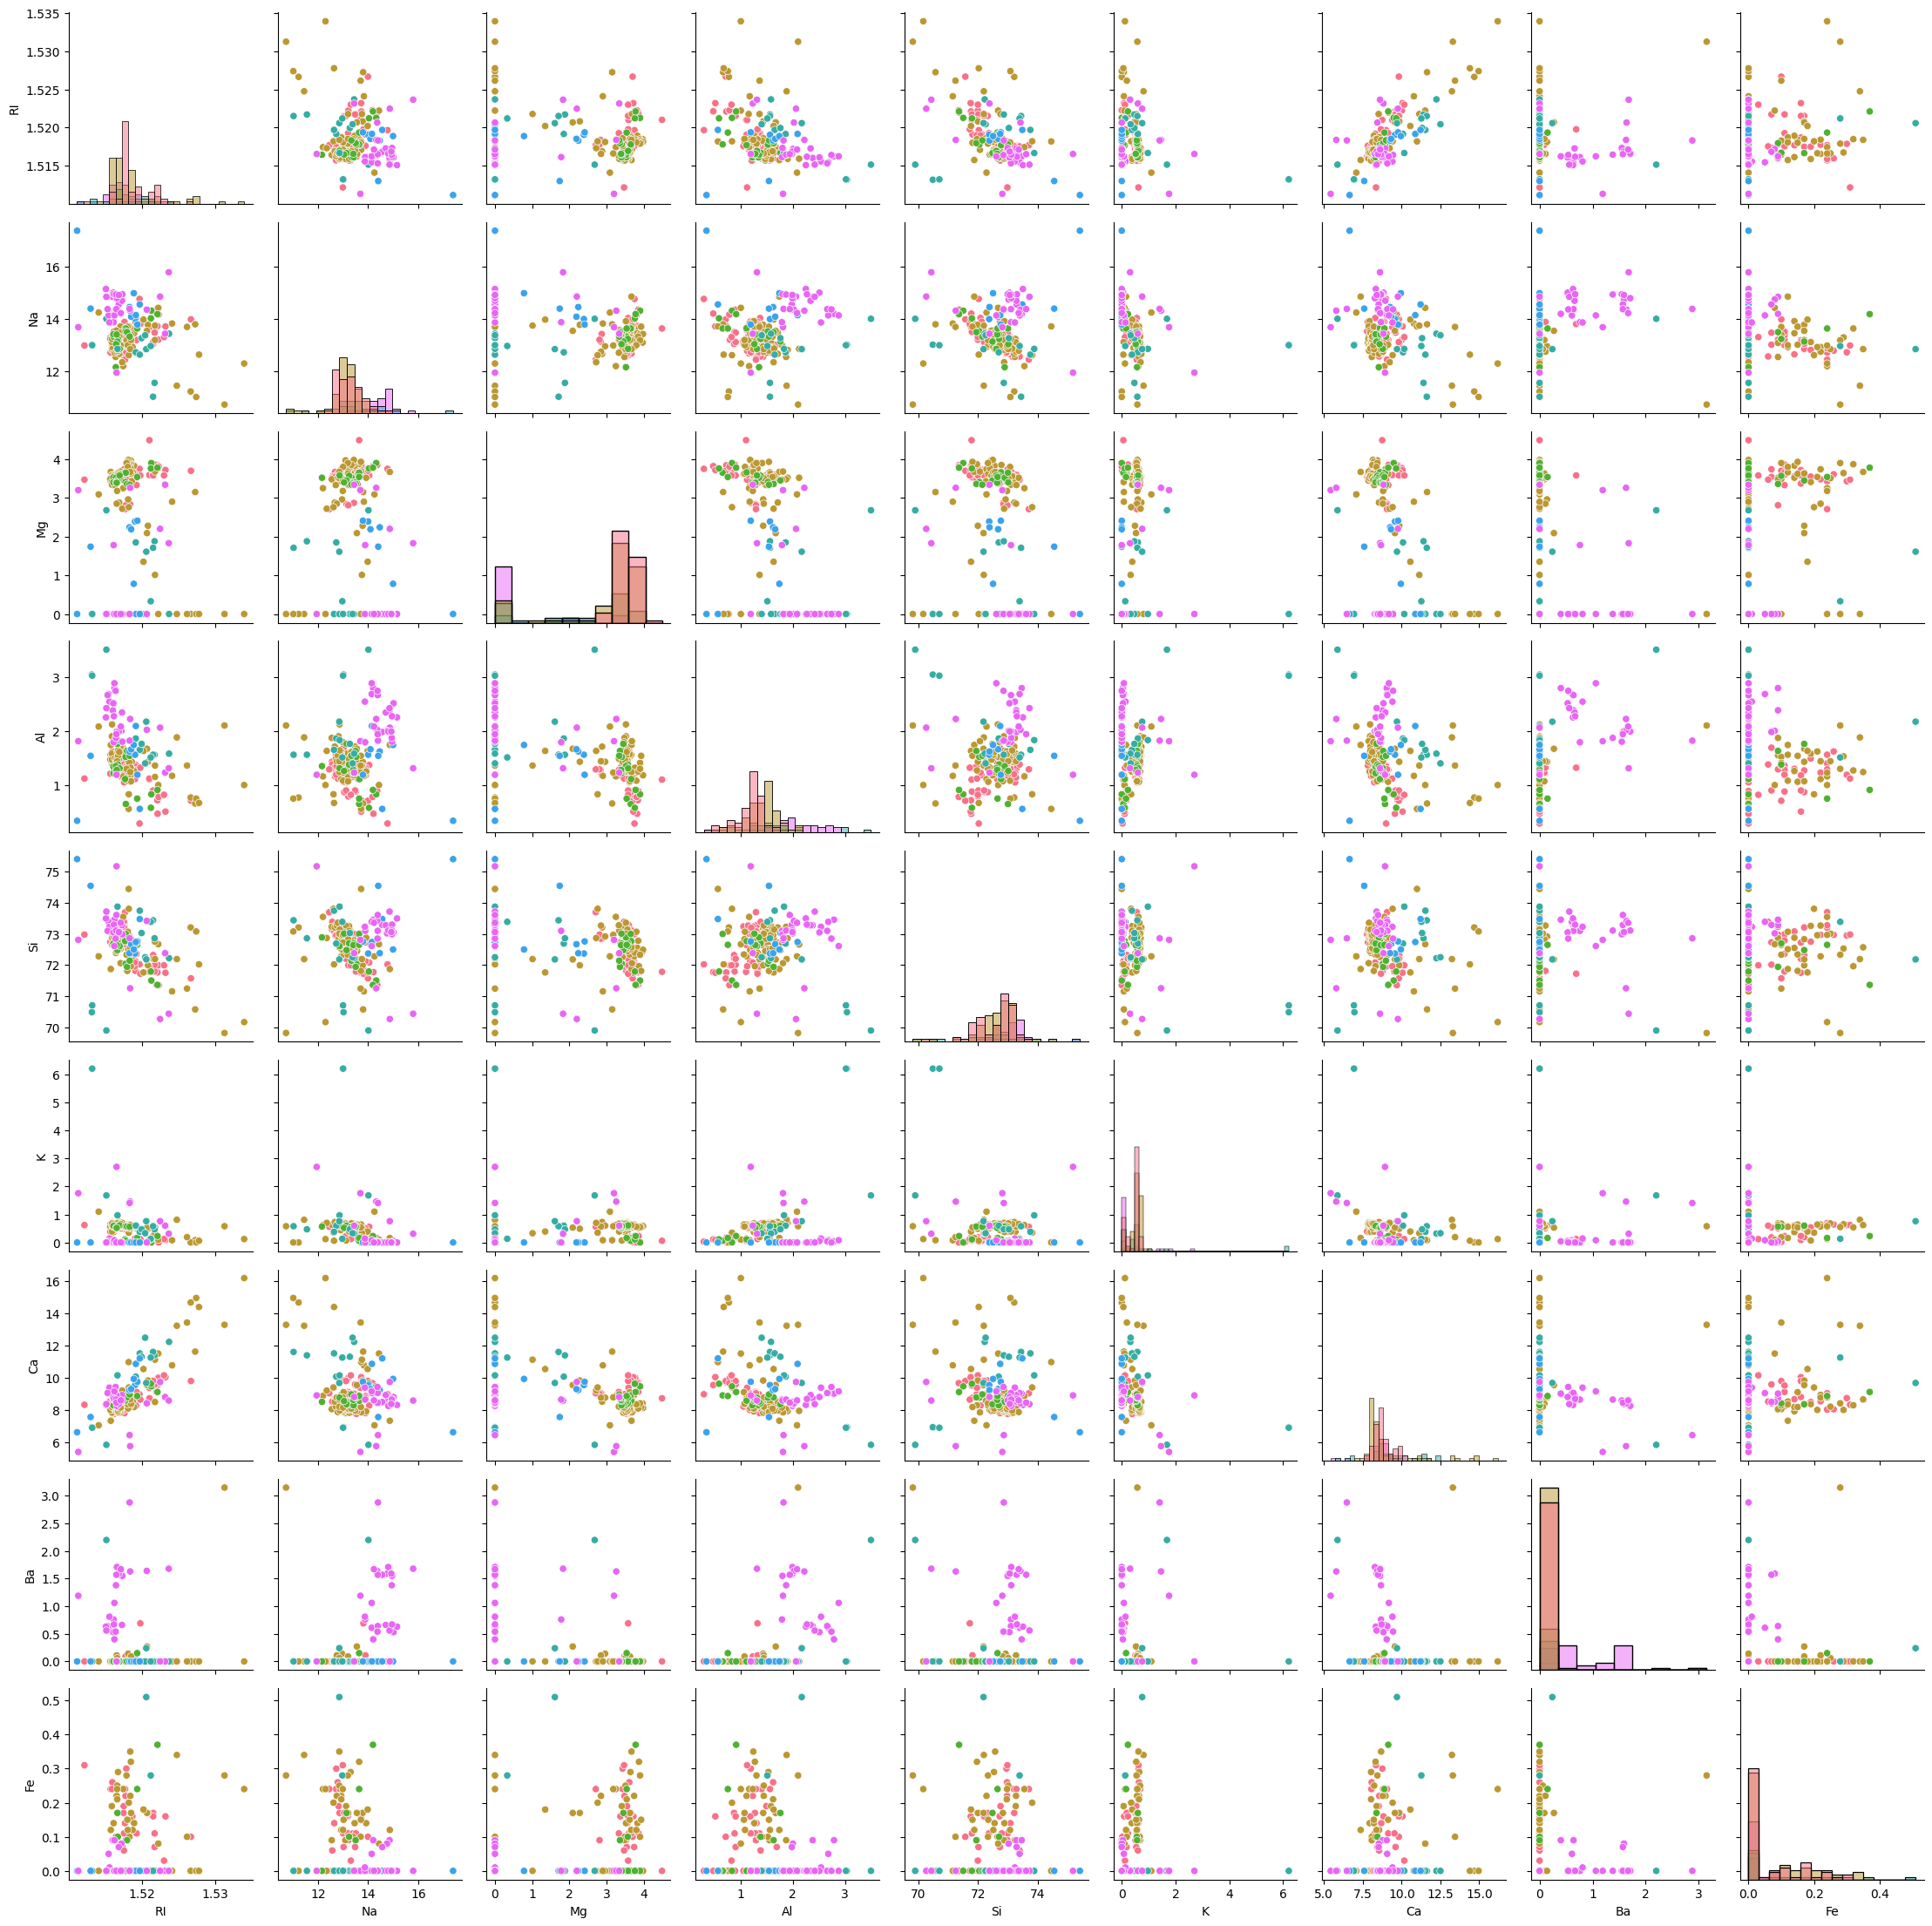

In [211]:
x_vars = df_glass.iloc[:, :-1].columns
y_vars = x_vars

palette = sns.color_palette("husl", 6)
g = sns.PairGrid(df_glass, hue = 'Type_of_glass', x_vars = x_vars, y_vars = y_vars, palette = palette)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

### Skuteczność KNN (domyślne parametry)

In [212]:
plain_knn_glass = plain_knn(X = X_glass, y = y_glass)
print(classification_report(*plain_knn_glass, zero_division = True))

              precision    recall  f1-score   support

           1       0.64      0.89      0.74        18
           2       0.78      0.74      0.76        19
           3       1.00      0.00      0.00         4
           5       1.00      1.00      1.00         3
           6       1.00      0.50      0.67         2
           7       1.00      0.88      0.93         8

    accuracy                           0.76        54
   macro avg       0.90      0.67      0.68        54
weighted avg       0.80      0.76      0.73        54



In [213]:
print(f'Precision: {precision_score(*plain_knn_glass, average = "weighted", zero_division = True)}')
print(f'Accuracy: {accuracy_score(*plain_knn_glass)}')
print(f'Recall: {recall_score(*plain_knn_glass, average = "weighted")}')
print(f'F1: {f1_score(*plain_knn_glass, average = "weighted")}')

Precision: 0.8018106995884774
Accuracy: 0.7592592592592593
Recall: 0.7592592592592593
F1: 0.7328468002886608


### Skuteczność KNN (walidacja krzyżowa - liczba foldów)

In [218]:
print('KFold accuracy: \n')
print(f'2-fold CV accuracy: {cv_knn(2, X_glass, y_glass)}')
print(f'5-fold CV accuracy: {cv_knn(5, X_glass, y_glass)}')
print(f'10-fold CV accuracy: {cv_knn(10, X_glass, y_glass)}')
print('\n\n')
print('LeaveOneOut accuracy: \n')
print(f'LOO accuracy: {loo_knn(X = X_glass, y = y_glass)}')

KFold accuracy: 

2-fold CV accuracy: 0.6588785046728971
5-fold CV accuracy: 0.6492801771871539
10-fold CV accuracy: 0.7012987012987013



LeaveOneOut accuracy: 

LOO accuracy: 0.7009345794392523


### Skuteczność KNN (walidacja krzyżowa - wartości hiperparametrów)

#### a) Liczba sąsiadów

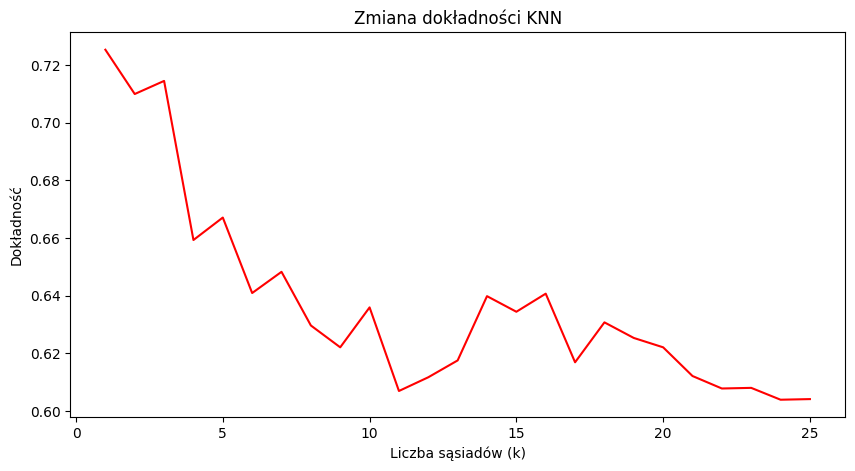

In [215]:
plot_acc_change(X_glass, y_glass)

#### b) Metryka

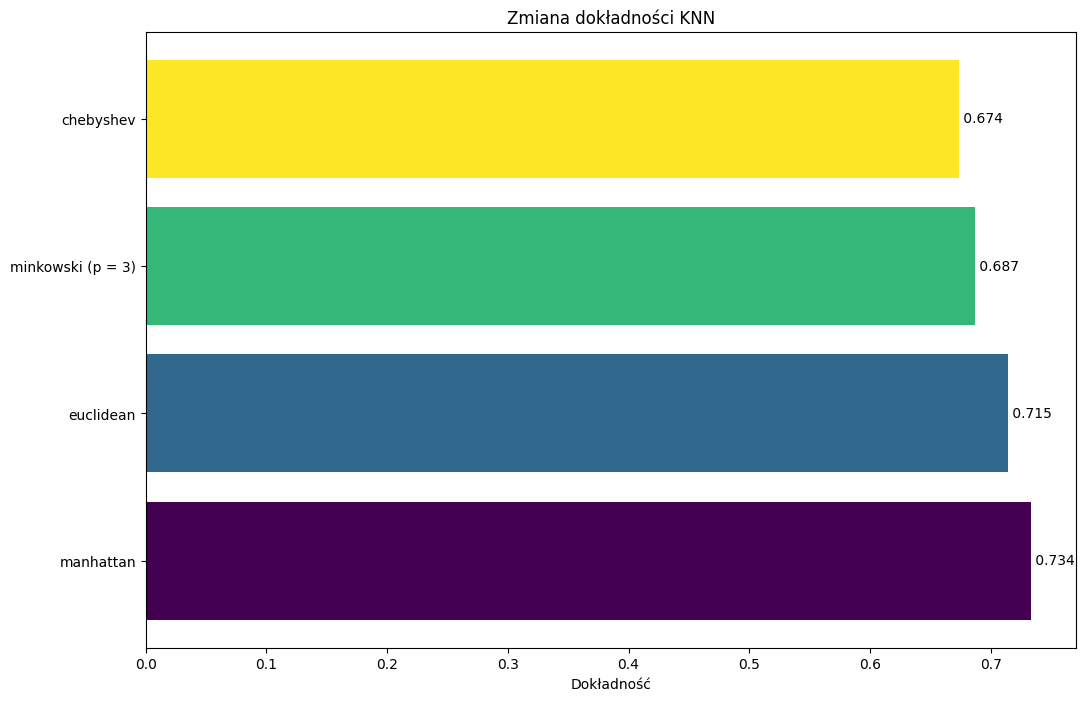

In [216]:
metrics_plot(X_glass, y_glass)

#### c) Sposób głosowania

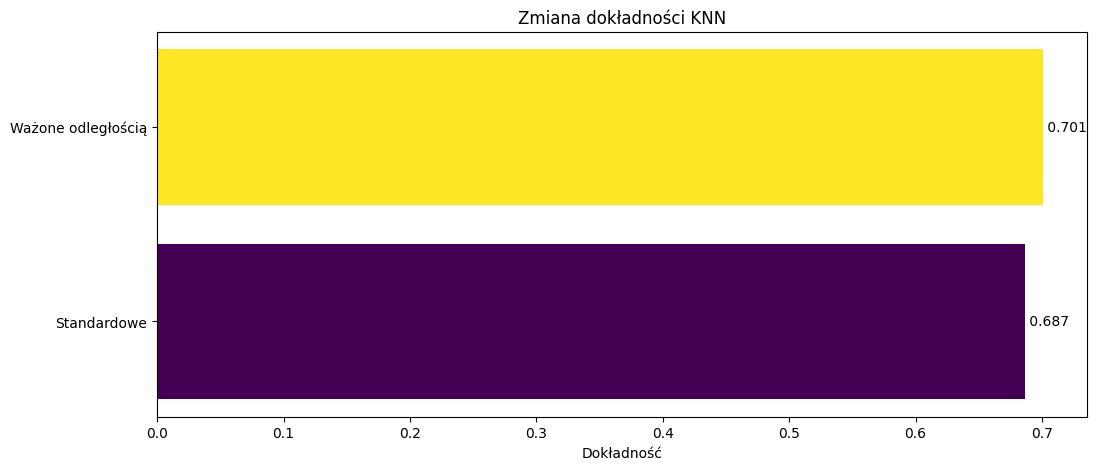

In [217]:
voting_plot(X_glass, y_glass)

## KFold vs StratifiedKFold

In [241]:
def compare_methods(X, y, title, k = 25):
    
    neighbors = np.arange(1, k + 1)
    metrics = ['manhattan', 'euclidean', 'minkowski (p = 3)', 'chebyshev']
    voting = ['Standardowe', 'Ważone odległością']    
    
    colors1 = plt.cm.viridis(np.linspace(0, 1, len(metrics)))
    colors2 = plt.cm.viridis(np.linspace(0, 1, len(voting))) 
        
    accuracy1 = np.array([cv_knn(10, X, y, n_neighbors = n, cv_method = KFold) for n in neighbors])
    accuracy2 = np.array([cv_knn(10, X, y, n_neighbors = n, cv_method = StratifiedKFold) for n in neighbors])
    accuracy3 = [cv_knn(10, X, y, n_neighbors = 3, metric = "manhattan", p = None, metric_params = None, cv_method = KFold)
               , cv_knn(10, X, y, n_neighbors = 3, metric = "euclidean", p = None, metric_params = None, cv_method = KFold)
               , cv_knn(10, X, y, n_neighbors = 3, metric = "minkowski", p = 3, metric_params = None, cv_method = KFold)
            #    , cv_knn(10, n_neighbors = 3, metric = "mahalanobis", p = None, metric_params={'V': np.cov(X)})
               , cv_knn(10, X, y, n_neighbors = 3, metric = "chebyshev", p = None, cv_method = KFold)]
    accuracy4 = [cv_knn(10, X, y, n_neighbors = 3, metric = "manhattan", p = None, metric_params = None, cv_method = StratifiedKFold)
               , cv_knn(10, X, y, n_neighbors = 3, metric = "euclidean", p = None, metric_params = None, cv_method = StratifiedKFold)
               , cv_knn(10, X, y, n_neighbors = 3, metric = "minkowski", p = 3, metric_params = None, cv_method = StratifiedKFold)
            #    , cv_knn(10, n_neighbors = 3, metric = "mahalanobis", p = None, metric_params={'V': np.cov(X)})
               , cv_knn(10, X, y, n_neighbors = 3, metric = "chebyshev", p = None, cv_method = StratifiedKFold)]
    accuracy5 = [cv_knn(10, X, y, weights = None, cv_method = KFold)
               , cv_knn(10, X, y, weights = 'distance', cv_method = KFold)]
    accuracy6 = [cv_knn(10, X, y, weights = None, cv_method = StratifiedKFold)
               , cv_knn(10, X, y, weights = 'distance', cv_method = StratifiedKFold)]

      
    fig, axs = plt.subplots(3, 2, figsize = (25, 20))
    axs[0, 0].plot(neighbors, accuracy1, color = 'red')
    axs[0, 1].plot(neighbors, accuracy2, color = 'red')
    axs[1, 0].barh(metrics, accuracy3, color = colors1)
    for i, (value, name) in enumerate(zip(accuracy3, metrics)):
        axs[1, 0].text(x = value, y=i, s=f' {round(float(value), 3)}',
            ha='left', va='center', fontsize=10)
    axs[1, 1].barh(metrics, accuracy4, color = colors1)
    for i, (value, name) in enumerate(zip(accuracy4, metrics)):
        axs[1, 1].text(x = value, y=i, s=f' {round(float(value), 3)}',
            ha='left', va='center', fontsize=10)
    axs[2, 0].barh(voting, accuracy5, color = colors2)
    for i, (value, name) in enumerate(zip(accuracy5, voting)):
        axs[2, 0].text(x = value, y=i, s=f' {round(float(value), 3)}',
            ha='left', va='center', fontsize=10)
    axs[2, 1].barh(voting, accuracy6, color = colors2)
    for i, (value, name) in enumerate(zip(accuracy6, voting)):
        axs[2, 1].text(x = value, y=i, s=f' {round(float(value), 3)}',
            ha='left', va='center', fontsize=10)
        
    axs[0, 0].set_title('Zmiana dokładności KNN (KFold)')
    axs[0, 0].set_xlabel('Liczba sąsiadów (k)')
    axs[0, 1].set_title('Zmiana dokładności KNN (StratifiedKFold)')
    axs[0, 0].set_xlabel('Liczba sąsiadów (k)')
    axs[1, 0].set_xlabel('Dokładność')
    axs[1, 1].set_xlabel('Dokładność')
    axs[2, 0].set_xlabel('Dokładność')
    axs[2, 1].set_xlabel('Dokładność')
    
    fig.suptitle(title, fontsize = 50)
    
    plt.show()

#### a) WINE

In [222]:
print('KFold accuracy: \n')
print(f'2-fold CV accuracy: {cv_knn(2, X_wine, y_wine)}')
print(f'5-fold CV accuracy: {cv_knn(5, X_wine, y_wine)}')
print(f'10-fold CV accuracy: {cv_knn(10, X_wine, y_wine)}')
print('\n\n')
print('StratifiedKFold accuracy: \n')
print(f'2-fold CV accuracy: {cv_knn(2, X_wine, y_wine, cv_method = StratifiedKFold)})')
print(f'5-fold CV accuracy: {cv_knn(5, X_wine, y_wine, cv_method = StratifiedKFold)}')
print(f'10-fold CV accuracy: {cv_knn(10, X_wine, y_wine, cv_method = StratifiedKFold)}')

KFold accuracy: 

2-fold CV accuracy: 0.7808988764044944
5-fold CV accuracy: 0.8036507936507936
10-fold CV accuracy: 0.8369281045751634



StratifiedKFold accuracy: 

2-fold CV accuracy: 0.7865168539325842)
5-fold CV accuracy: 0.8093650793650793
10-fold CV accuracy: 0.8375816993464053


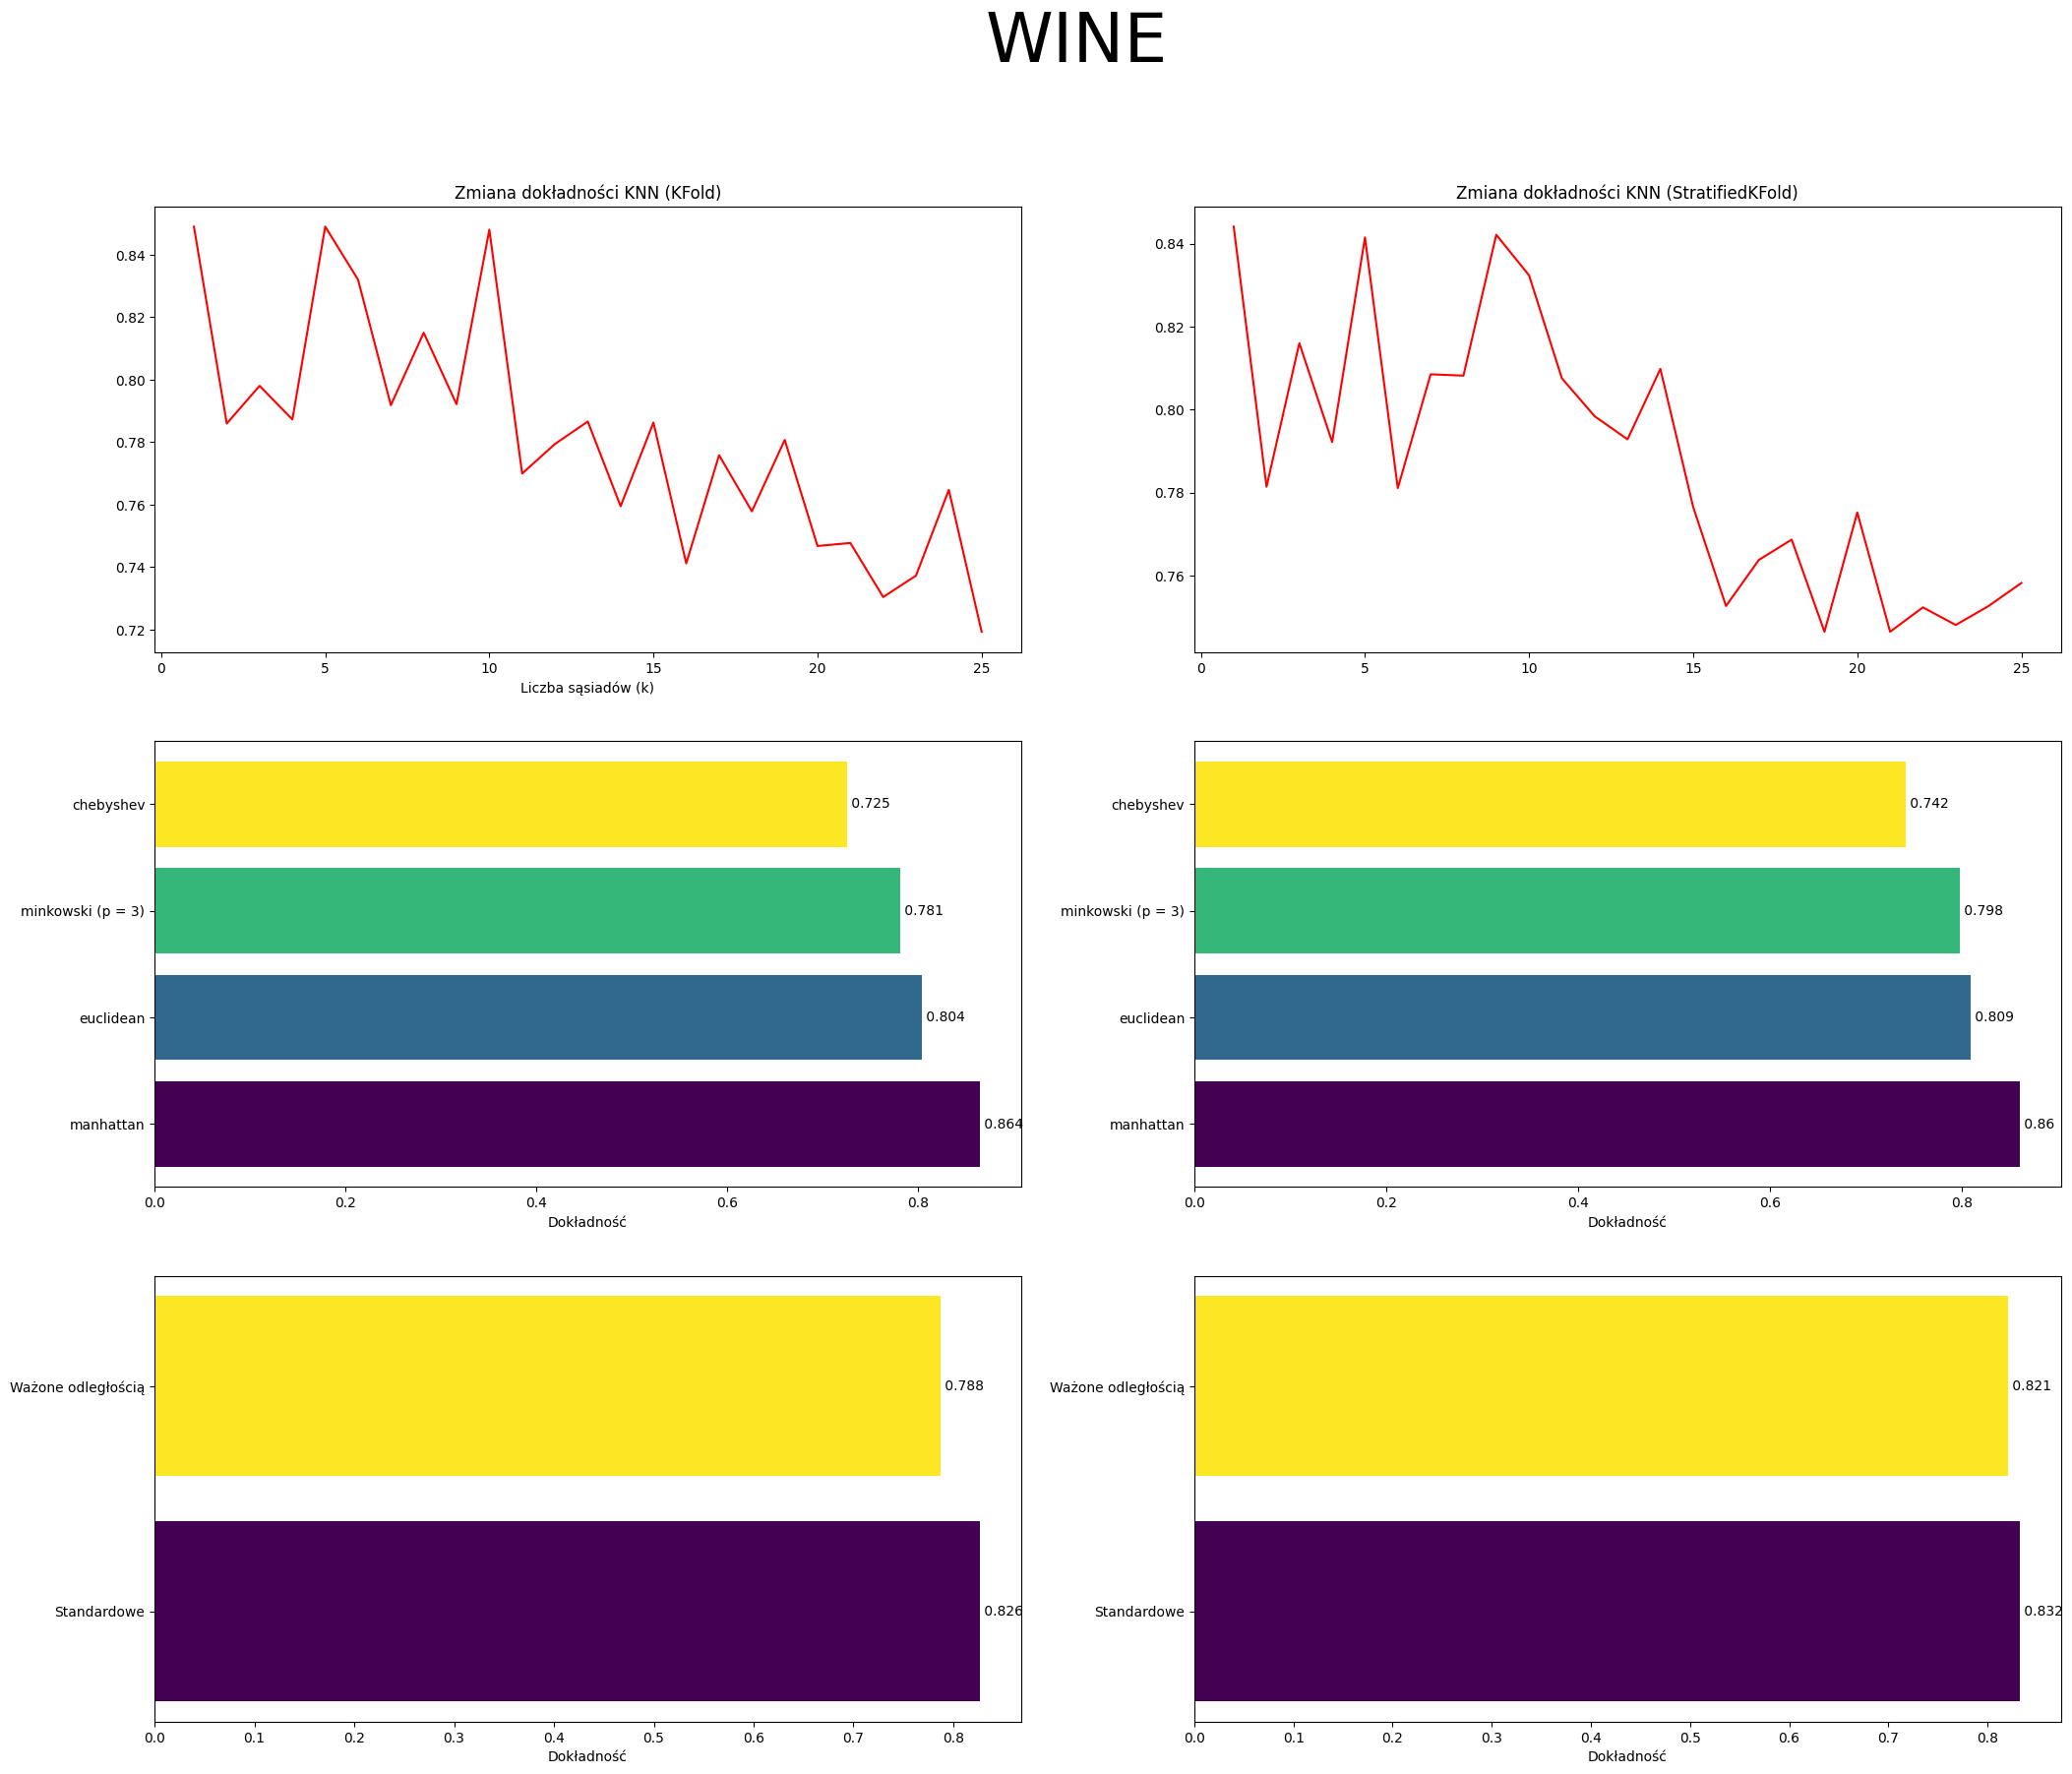

In [243]:
compare_methods(X_wine, y_wine, 'WINE')

#### b) GLASS

In [219]:
print('KFold accuracy: \n')
print(f'2-fold CV accuracy: {cv_knn(2, X_glass, y_glass)}')
print(f'5-fold CV accuracy: {cv_knn(5, X_glass, y_glass)}')
print(f'10-fold CV accuracy: {cv_knn(10, X_glass, y_glass)}')
print('\n\n')
print('StratifiedKFold accuracy: \n')
print(f'2-fold CV accuracy: {cv_knn(2, X_glass, y_glass, cv_method = StratifiedKFold)})')
print(f'5-fold CV accuracy: {cv_knn(5, X_glass, y_glass, cv_method = StratifiedKFold)}')
print(f'10-fold CV accuracy: {cv_knn(10, X_glass, y_glass, cv_method = StratifiedKFold)}')

KFold accuracy: 

2-fold CV accuracy: 0.6401869158878504
5-fold CV accuracy: 0.6585825027685493
10-fold CV accuracy: 0.6861471861471862



StratifiedKFold accuracy: 

2-fold CV accuracy: 0.6308411214953271)
5-fold CV accuracy: 0.6776301218161684
10-fold CV accuracy: 0.6768398268398268


c:\Users\20meh\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


c:\Users\20meh\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\20meh\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\20meh\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\20meh\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\20meh\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least popul

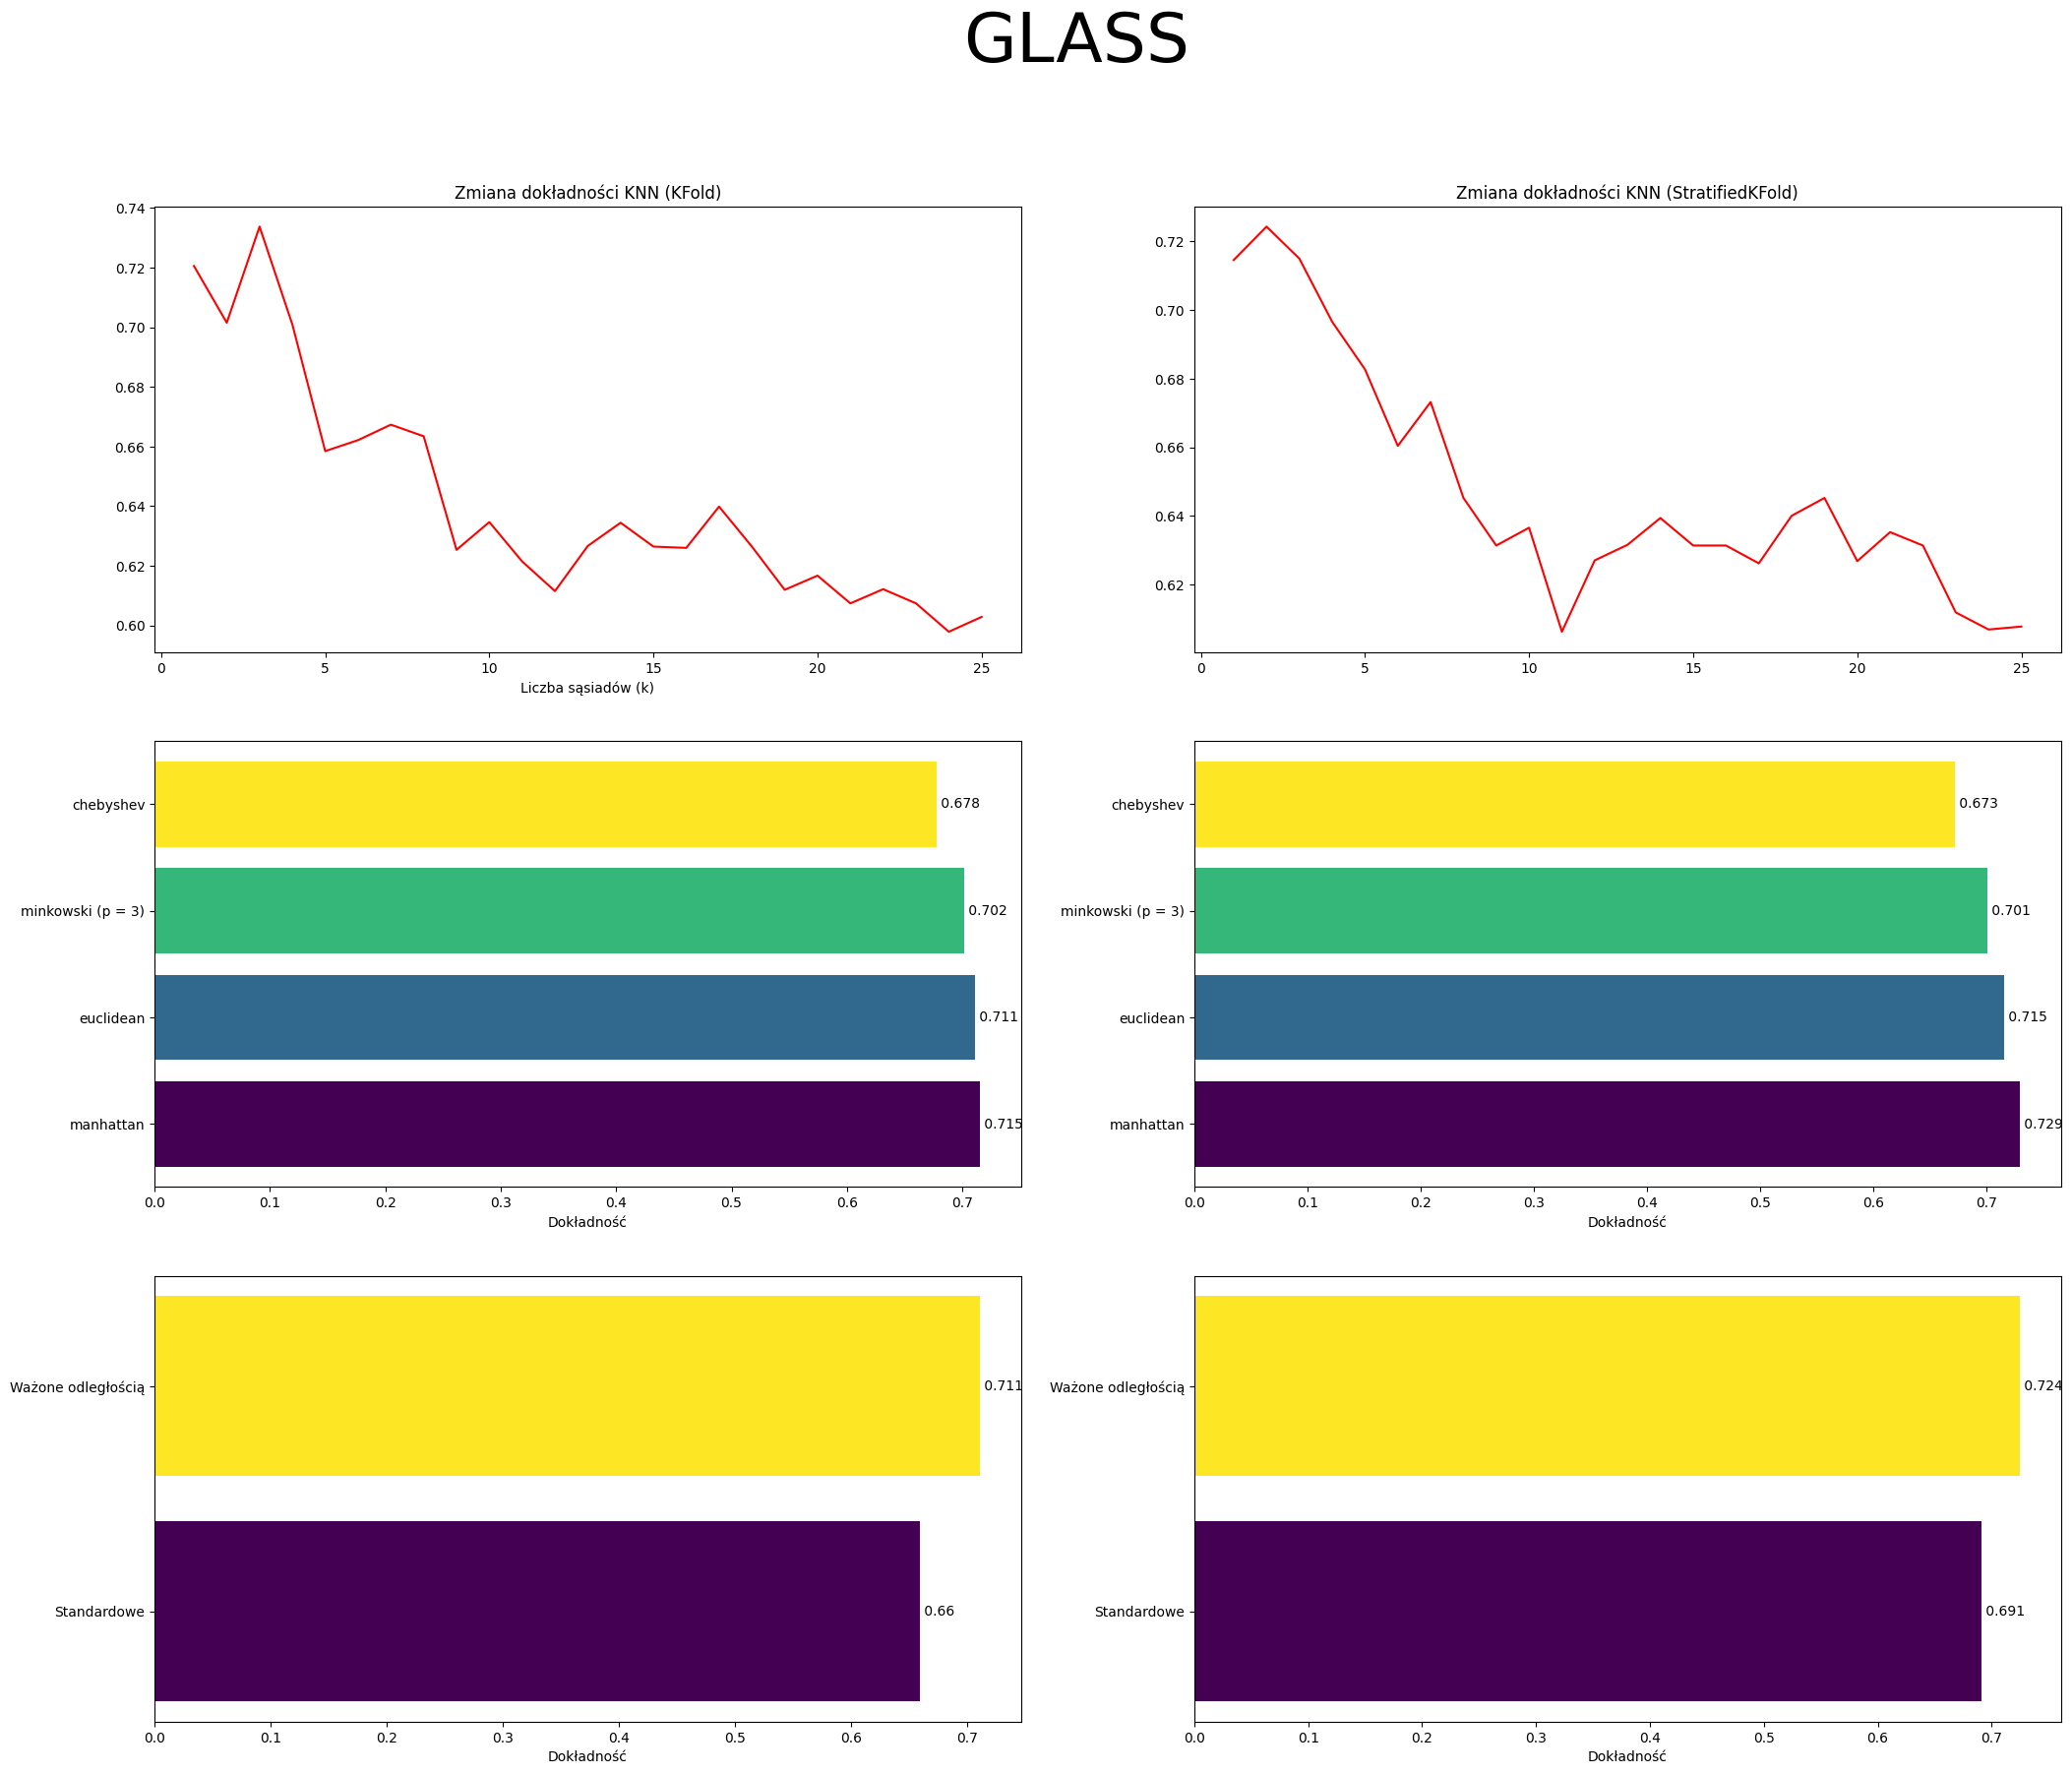

In [244]:
compare_methods(X_glass, y_glass, 'GLASS')

## Ewaluacja modelu po zastosowaniu PCA i tSNE

In [275]:
def dim_reduce(X, y, method = 'PCA'):
    normalize = Normalizer()
    reduce = method(n_components = 3)
    pipe = Pipeline([('normalize', normalize), ('reduce', reduce)])
    X = pipe.fit_transform(X)
    df = pd.DataFrame({'component_1' : X[:, 0] 
                       , 'component_2' : X[:, 1]
                       , 'component_3' : X[:, 2]
                       , 'class' : y})
    return df

#### a) WINE

In [276]:
pca_wine = dim_reduce(X_wine, y_wine, method = PCA)
tsne_wine = dim_reduce(X_wine, y_wine, method = TSNE)

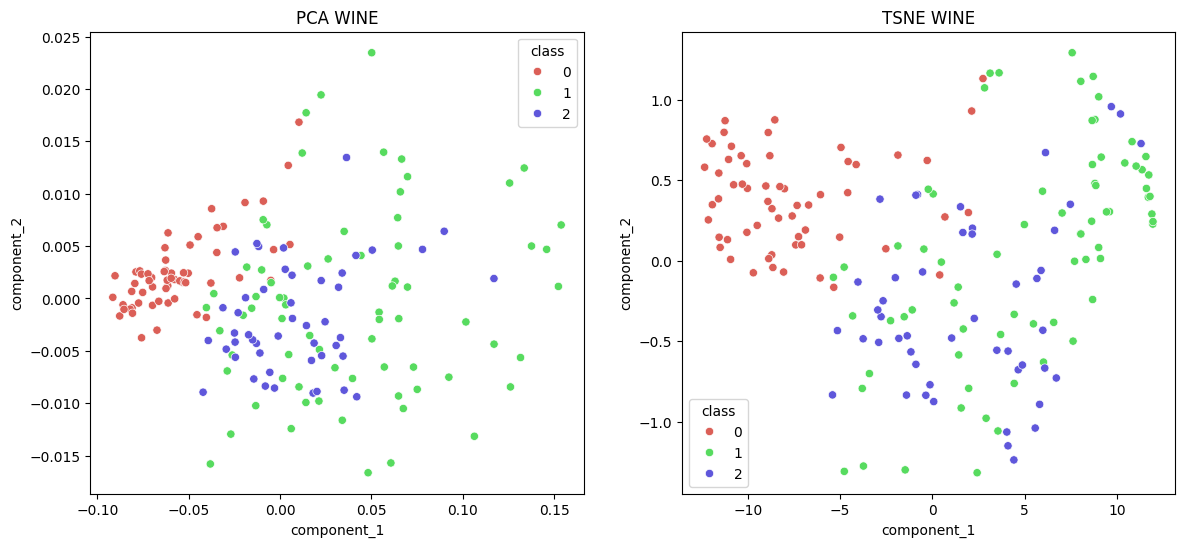

In [278]:
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
sns.scatterplot(data = pca_wine
                , x = pca_wine.columns[0]
                , y = pca_wine.columns[1]
                , hue = 'class'
                , palette = sns.color_palette('hls', 3)
                , ax = axs[0])
axs[0].set_title('PCA WINE')
sns.scatterplot(data = tsne_wine
                , x = tsne_wine.columns[0]
                , y = tsne_wine.columns[1]
                , hue = 'class'
                , palette = sns.color_palette('hls', 3)
                , ax = axs[1])
axs[1].set_title('TSNE WINE')
plt.show()
plt.show()

In [281]:
X_wine_pca, y_wine_pca = np.array(pca_wine.iloc[:, :3]), np.array(pca_wine.iloc[:, -1]).reshape(1, -1)[0]
X_wine_tsne, y_wine_tsne = np.array(tsne_wine.iloc[:, :3]), np.array(tsne_wine.iloc[:, -1]).reshape(1, -1)[0]

In [282]:
print('PCA WINE \n')
print('KFold accuracy: \n')
print(f'2-fold CV accuracy: {cv_knn(2, X_wine_pca, y_wine_pca)}')
print(f'5-fold CV accuracy: {cv_knn(5, X_wine_pca, y_wine_pca)}')
print(f'10-fold CV accuracy: {cv_knn(10, X_wine_pca, y_wine_pca)}')
print('\n\n')
print('LeaveOneOut accuracy: \n')
print(f'LOO accuracy: {loo_knn(X_wine_pca, y_wine_pca)}')

PCA WINE 

KFold accuracy: 

2-fold CV accuracy: 0.7865168539325842
5-fold CV accuracy: 0.8425396825396824
10-fold CV accuracy: 0.8539215686274509



LeaveOneOut accuracy: 

LOO accuracy: 0.8539325842696629


In [283]:
print('tSNE WINE \n')
print('KFold accuracy: \n')
print(f'2-fold CV accuracy: {cv_knn(2, X_wine_tsne, y_wine_tsne)}')
print(f'5-fold CV accuracy: {cv_knn(5, X_wine_tsne, y_wine_tsne)}')
print(f'10-fold CV accuracy: {cv_knn(10, X_wine_tsne, y_wine_tsne)}')
print('\n\n')
print('LeaveOneOut accuracy: \n')
print(f'LOO accuracy: {loo_knn(X_wine_tsne, y_wine_tsne)}')

tSNE WINE 

KFold accuracy: 

2-fold CV accuracy: 0.7247191011235955
5-fold CV accuracy: 0.7755555555555554
10-fold CV accuracy: 0.7473856209150327



LeaveOneOut accuracy: 

LOO accuracy: 0.7696629213483146


#### b) GLASS

In [284]:
pca_glass = dim_reduce(X_glass, y_glass, method = PCA)
tsne_glass = dim_reduce(X_glass, y_glass, method = TSNE)

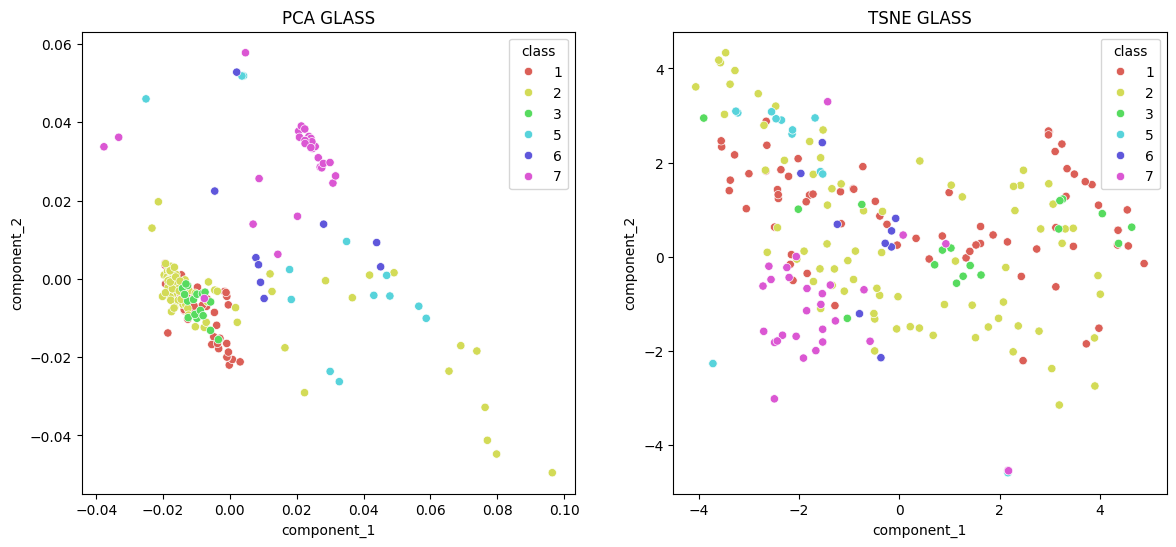

In [285]:
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
sns.scatterplot(data = pca_glass
                , x = pca_glass.columns[0]
                , y = pca_glass.columns[1]
                , hue = 'class'
                , palette = sns.color_palette('hls', 6)
                , ax = axs[0])
axs[0].set_title('PCA GLASS')
sns.scatterplot(data = tsne_glass
                , x = tsne_glass.columns[0]
                , y = tsne_glass.columns[1]
                , hue = 'class'
                , palette = sns.color_palette('hls', 6)
                , ax = axs[1])
axs[1].set_title('TSNE GLASS')
plt.show()
plt.show()

In [286]:
X_glass_pca, y_glass_pca = np.array(pca_glass.iloc[:, :3]), np.array(pca_glass.iloc[:, -1]).reshape(1, -1)[0]
X_glass_tsne, y_glass_tsne = np.array(tsne_glass.iloc[:, :3]), np.array(tsne_glass.iloc[:, -1]).reshape(1, -1)[0]

In [287]:
print('PCA GLASS \n')
print('KFold accuracy: \n')
print(f'2-fold CV accuracy: {cv_knn(2, X_glass_pca, y_glass_pca)}')
print(f'5-fold CV accuracy: {cv_knn(5, X_glass_pca, y_glass_pca)}')
print(f'10-fold CV accuracy: {cv_knn(10, X_glass_pca, y_glass_pca)}')
print('\n\n')
print('LeaveOneOut accuracy: \n')
print(f'LOO accuracy: {loo_knn(X_glass_pca, y_glass_pca)}')

PCA GLASS 

KFold accuracy: 

2-fold CV accuracy: 0.6635514018691588
5-fold CV accuracy: 0.6630121816168328
10-fold CV accuracy: 0.6777056277056277



LeaveOneOut accuracy: 

LOO accuracy: 0.6728971962616822


In [288]:
print('tSNE WINE \n')
print('KFold accuracy: \n')
print(f'2-fold CV accuracy: {cv_knn(2, X_glass_tsne, y_glass_tsne)}')
print(f'5-fold CV accuracy: {cv_knn(5, X_glass_tsne, y_glass_tsne)}')
print(f'10-fold CV accuracy: {cv_knn(10, X_glass_tsne, y_glass_tsne)}')
print('\n\n')
print('LeaveOneOut accuracy: \n')
print(f'LOO accuracy: {loo_knn(X_glass_tsne, y_glass_tsne)}')

tSNE WINE 

KFold accuracy: 

2-fold CV accuracy: 0.6448598130841121
5-fold CV accuracy: 0.7049833887043189
10-fold CV accuracy: 0.7147186147186148



LeaveOneOut accuracy: 

LOO accuracy: 0.719626168224299
